# Overview of Neural Networks

In [14]:
## Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

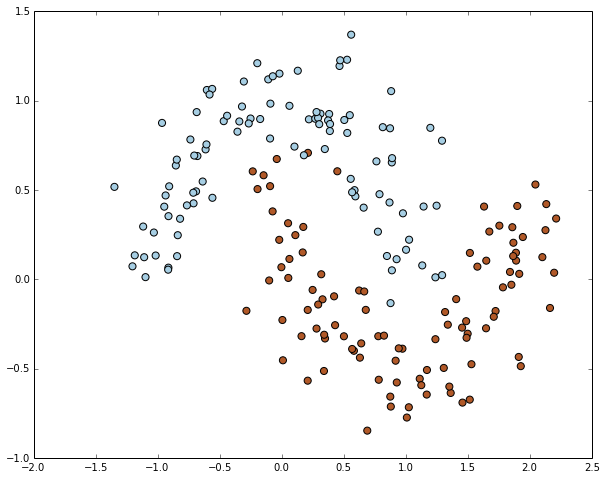

In [22]:
## Generate non-separable data.
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=50, c=y, cmap=plt.cm.Paired)

In [16]:
## We start by implementing a logistic (linear) classifier.
logistic = sklearn.linear_model.LogisticRegressionCV()
logistic.fit(X,y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [20]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.03
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], s = 50, c=y, cmap=plt.cm.Paired)

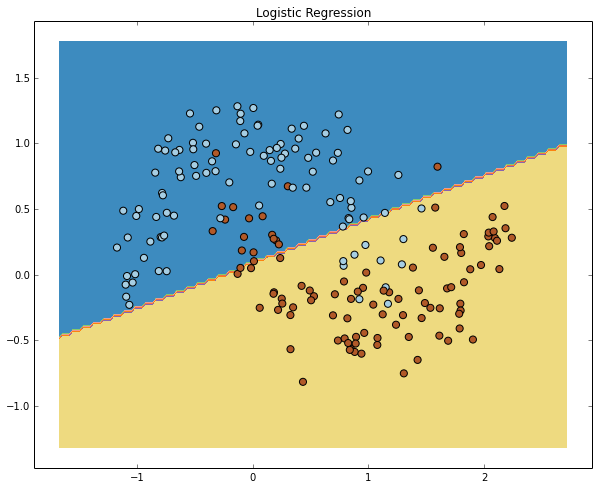

In [21]:
plot_decision_boundary(lambda x: logistic.predict(x))
plt.title("Logistic Regression")

### Moving from logistic to neural networks.

Logistic regression correctly classifies a good number of observations, but doesn't pick up the moon shape from the data. Now we will try a neural network, on which we have:

**1)** One input layer for each dimension (2 in total).  
**2)** One input layer for each classification (2 in total).  
**3)** An arbitrary larger number of hidden layers.  
**4)** A *tanh* activation function for the input layer, and a *softmax* for the output one.

*Input of layer 1*: $ \quad z_1 = xW_1 + b_1 \qquad$ *Output of layer 1*: $ \quad a_1 = tanh(z_1)$

*Input of layer 2*: $ \quad z_2 = a_1W_1 + b_w \qquad$ *Output of layer 1*: $ \quad a_2 = softmax(z_2) = \hat{y}$

The parameters our model needs to learn are then $(W_1, W_2, b_1, b_2)$. For this we will use *cross-entropy loss function*, defined as:

$L(y,\hat{y}) = \sum_N \sum_C y_{n,1} log(\hat{y})_{n,i}$

Where $N$ are the total of observations and $C$ the different classes.